In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from matplotlib.pyplot import figure #bigger figure


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
#df = df.append({'Date':pd.to_datetime('2021-10-31'),'Infected':4284}, ignore_index = True) #anomaly
#df = df.append({'Date':pd.to_datetime('2021-11-01'),'Infected':5000}, ignore_index = True) #anomaly
#df = df.append({'Date':pd.to_datetime('2021-11-02'),'Infected':354}, ignore_index = True) #anomaly

df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
652,2021-10-29,291.0
653,2021-10-30,283.0
654,2021-10-31,215.0
655,2021-11-01,80.0


In [5]:
pred_covid('GRU', df,1)

GRU loaded


,Date,Predict Infected
0,2021-11-03,212.072071
1,2021-11-04,222.862002
2,2021-11-05,195.599026
3,2021-11-06,185.166805


In [6]:
def get_prediction(model, df): #model = 'GRU' or 'LSTM'
    pred_arr = []
    for model_idx in [1,2,3]:
        #print(model,model_idx,pred_covid(model, df,model_idx))
        pred_arr.append(np.array(pred_covid(model, df,model_idx)['Predict Infected'].values))
    return np.array(pred_arr)

In [7]:
def get_PI(pred_arr):
    intervals = []
    means = []
    uppers = []
    lowers = []
    for idx in [0,1,2,3]:
        cov_std = pred_arr[:,idx].std()
        cov_interval = cov_std*1.96
        cov_mean = pred_arr[:,idx].mean()
        cov_lower = cov_mean - cov_interval
        if (cov_lower<0):
            cov_lower = 0
        cov_upper = cov_mean + cov_interval
        print(pred_arr[:,idx], 'Interval: ',cov_interval , 'Lower: ',cov_lower, 'Mean: ',cov_mean, 'Upper: ',cov_upper)
        
        intervals.append(int(cov_interval))
        means.append(int(cov_mean))
        uppers.append(int(cov_upper))
        lowers.append(int(cov_lower))
    
    return intervals, means, uppers, lowers

### Looping through 2 models to get y_pred_mean for XGB

In [8]:
def get_all_pred_data(df):
    y_pred_arr = []
    cov_intervals_arr = []
    cov_uppers_arr = []
    cov_lowers_arr = []
    for model_type in ['LSTM','GRU']:
        pred_arr = get_prediction(model_type,df)
        cov_intervals, cov_means, cov_uppers, cov_lowers = get_PI(pred_arr)
        y_pred = cov_means
        y_pred_arr.append(y_pred)
        cov_intervals_arr.append(cov_intervals)
        cov_uppers_arr.append(cov_uppers)
        cov_lowers_arr.append(cov_lowers)    

        start_date = str(df[-14:]['Date'].iloc[0])[:10]
        end_date = pred_covid(model_type, df,3)['Date'][3]
        time_range = pd.date_range(start = start_date, end= end_date)
        print('start date: ',start_date)
        print('end date: ',end_date)

        figure(figsize=(18, 5), dpi=80)
        plt.plot(time_range[:-4], df['Infected'][-14:], label='Observed')
        plt.plot(time_range[-4:], y_pred, label='Prediction')

        plt.errorbar(time_range[-4], y_pred[0], yerr=cov_intervals[0], color='black', fmt='o', label='95% Prediction Interval')
        plt.errorbar(time_range[-3], y_pred[1], yerr=cov_intervals[1], color='black', fmt='o')
        plt.errorbar(time_range[-2], y_pred[2], yerr=cov_intervals[2], color='black', fmt='o')
        plt.errorbar(time_range[-1], y_pred[3], yerr=cov_intervals[3], color='black', fmt='o')

        plt.xlabel('Date')
        plt.ylabel('Cases')
        plt.xticks(time_range,rotation=45)
        plt.title('COVID-19 Prediction in Japan \nfrom {0} to {1} with {2}'.format(start_date, end_date, model_type))
        plt.legend()
        plt.ylim(0, None) # Or similarly "plt.ylim(0)" #important
        plt.show()

    y_pred_arr = np.array(y_pred_arr) #means
    cov_intervals_arr = np.array(cov_intervals_arr)
    cov_lowers_arr = np.array(cov_lowers_arr)
    cov_uppers_arr = np.array(cov_uppers_arr)
    
    return y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr



LSTM loaded
LSTM loaded
LSTM loaded
[249.17652434 216.57397228 123.19806948] Interval:  104.64058160561987 Lower:  91.6756070973608 Mean:  196.31618870298067 Upper:  300.95677030860054
[269.28224939 228.71031636 144.01852056] Interval:  102.28325886018412 Lower:  111.72043657812141 Mean:  214.00369543830553 Upper:  316.28695429848966
[259.33431119 224.36621341 153.64519894] Interval:  86.16676140931281 Lower:  126.28181310388413 Mean:  212.44857451319695 Upper:  298.61533592250976
[207.57609874 199.00981659 131.6230222 ] Interval:  66.5734519427465 Lower:  112.82952723250322 Mean:  179.40297917524973 Upper:  245.97643111799624
LSTM loaded
start date:  2021-10-20
end date:  2021-11-06


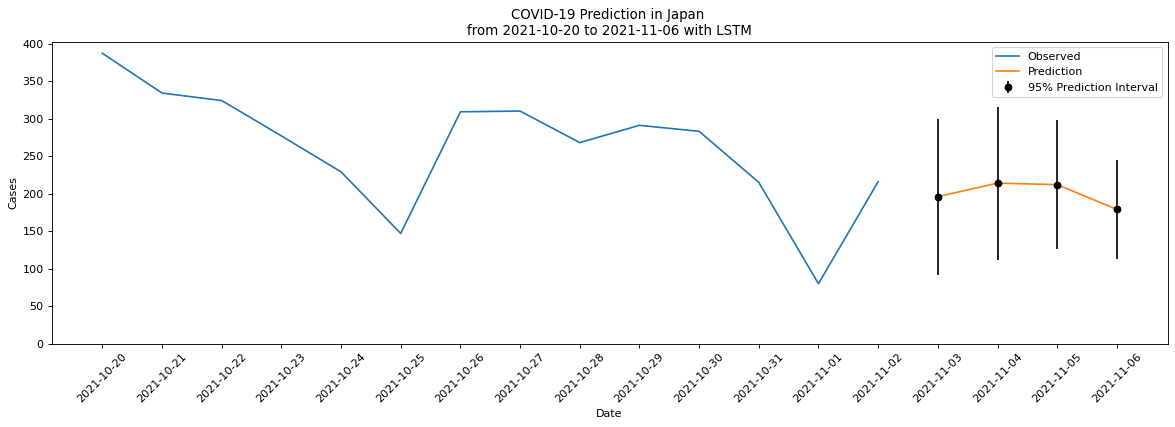

GRU loaded
GRU loaded
GRU loaded
[212.07207114 255.78670168 260.41583318] Interval:  42.68980743638653 Lower:  200.06839456009885 Mean:  242.75820199648538 Upper:  285.4480094328719
[222.86200231 276.14666784 295.37641937] Interval:  60.11866551341951 Lower:  204.67636432546038 Mean:  264.7950298388799 Upper:  324.9136953522994
[195.59902591 279.03382504 262.33389515] Interval:  70.65006663749864 Lower:  175.0055153931156 Mean:  245.65558203061423 Upper:  316.3056486681129
[185.16680542 261.06261641 225.8505156 ] Interval:  60.78188077286579 Lower:  163.2447650365462 Mean:  224.026645809412 Upper:  284.8085265822778
GRU loaded
start date:  2021-10-20
end date:  2021-11-06


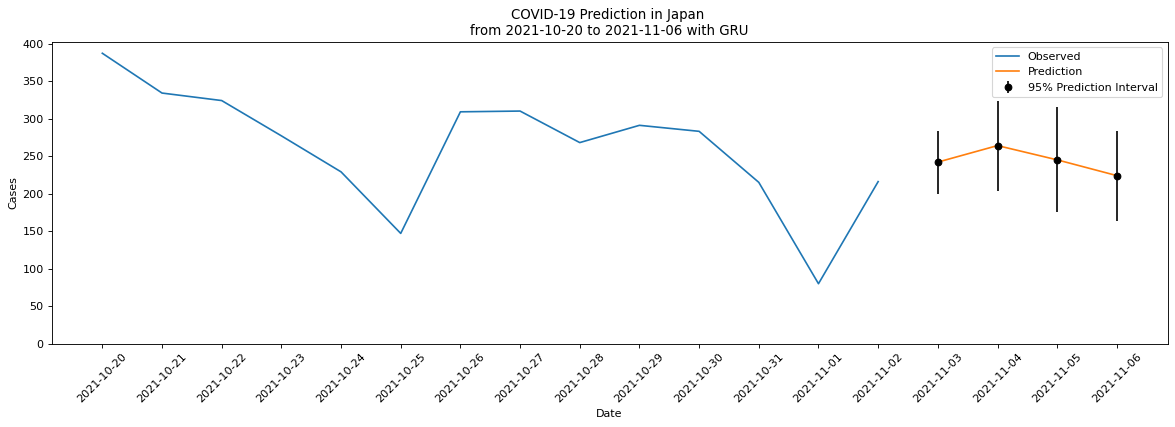

Wall time: 14.5 s


In [9]:
%%time
y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr = get_all_pred_data(df)

In [10]:
# lstm, gru
# 0,    1 
y_pred_arr

array([[196, 214, 212, 179],
       [242, 264, 245, 224]])

In [11]:
print('mean pred lstm: ',y_pred_arr[0])
print('mean pred gru:  ',y_pred_arr[1])

mean pred lstm:  [196 214 212 179]
mean pred gru:   [242 264 245 224]


In [12]:
X_test_xgb = y_pred_arr.T #transpose into (4,2)
print(X_test_xgb.shape)
print(X_test_xgb)


(4, 2)
[[196 242]
 [214 264]
 [212 245]
 [179 224]]


In [13]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.load_model('xgb_lstm_gru_mean_Oct1.json')
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

In [14]:
def get_LSTM_preds(day_idx, y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr): #day_idx = 0 1 2 3
    return y_pred_arr[0][day_idx], cov_intervals_arr[0][day_idx], cov_lowers_arr[0][day_idx], cov_uppers_arr[0][day_idx]

def get_GRU_preds(day_idx, y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr): #day_idx = 0 1 2 3
    return y_pred_arr[1][day_idx], cov_intervals_arr[1][day_idx], cov_lowers_arr[1][day_idx], cov_uppers_arr[1][day_idx]

In [15]:
y_pred_xgb = xgb_clf.predict(X_test_xgb)
y_pred_xgb

array([0, 0, 0, 0])

In [16]:
def xgb_picks(y_pred_xgb, y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr): # XGB chooses LSTM or GRU predictions at each day
    res = []
    for i in range(len(y_pred_xgb)):
        if y_pred_xgb[i] == 0: #LSTM
            y_pred_cov, cov_interval, cov_lower, cov_upper = get_LSTM_preds(i, y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr)
            res.append(['LSTM', y_pred_cov, cov_interval, cov_lower, cov_upper])
        else: #GRU
            y_pred_cov, cov_interval, cov_lower, cov_upper = get_GRU_preds(i, y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr)
            res.append(['GRU', y_pred_cov, cov_interval, cov_lower, cov_upper])
    return np.array(res)


xgb_picks_arr = xgb_picks(y_pred_xgb, y_pred_arr, cov_intervals_arr, cov_lowers_arr, cov_uppers_arr)

GRU loaded
start date:  2021-10-20
end date:  2021-11-06


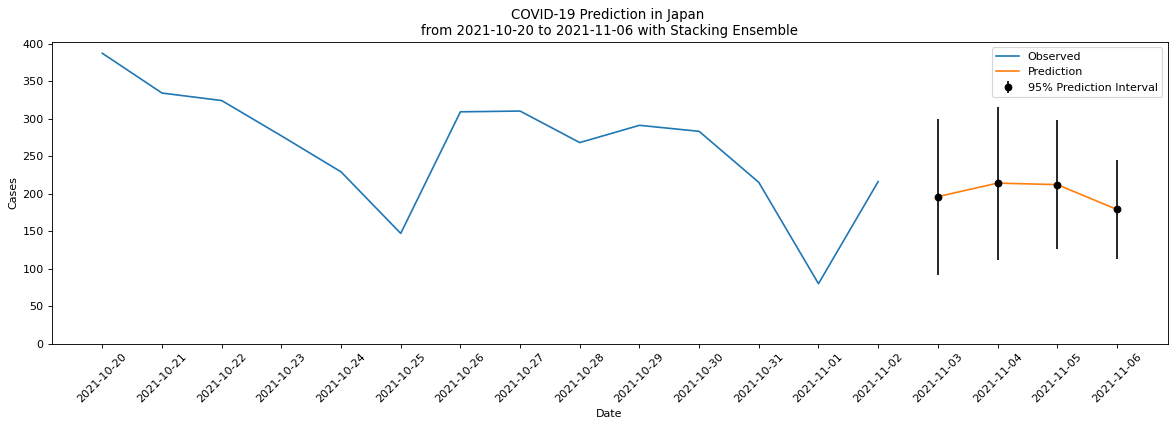

In [17]:
start_date = str(df[-14:]['Date'].iloc[0])[:10]
end_date = pred_covid("GRU", df,3)['Date'][3]
time_range = pd.date_range(start = start_date, end= end_date)
print('start date: ',start_date)
print('end date: ',end_date)

figure(figsize=(18, 5), dpi=80)
y_pred = xgb_picks_arr[:,1].astype(int)
cov_intervals = xgb_picks_arr[:,2].astype(int)
plt.plot(time_range[:-4], df['Infected'][-14:], label='Observed')
plt.plot(time_range[-4:], y_pred, label='Prediction')

plt.errorbar(time_range[-4], y_pred[0], yerr=cov_intervals[0], color='black', fmt='o', label='95% Prediction Interval')
plt.errorbar(time_range[-3], y_pred[1], yerr=cov_intervals[1], color='black', fmt='o')
plt.errorbar(time_range[-2], y_pred[2], yerr=cov_intervals[2], color='black', fmt='o')
plt.errorbar(time_range[-1], y_pred[3], yerr=cov_intervals[3], color='black', fmt='o')

plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(time_range,rotation=45)
plt.title('COVID-19 Prediction in Japan \nfrom {0} to {1} with Stacking Ensemble'.format(start_date, end_date))
plt.legend()
plt.ylim(0, None) # Or similarly "plt.ylim(0)" #important
plt.show()

### Sample code, do not delete

In [18]:
%%time
model_type = 'GRU'
pred_arr = get_prediction(model_type,df)
cov_intervals, cov_means, cov_uppers, cov_lowers = get_PI(pred_arr)


GRU loaded
GRU loaded
GRU loaded
[212.07207114 255.78670168 260.41583318] Interval:  42.68980743638653 Lower:  200.06839456009885 Mean:  242.75820199648538 Upper:  285.4480094328719
[222.86200231 276.14666784 295.37641937] Interval:  60.11866551341951 Lower:  204.67636432546038 Mean:  264.7950298388799 Upper:  324.9136953522994
[195.59902591 279.03382504 262.33389515] Interval:  70.65006663749864 Lower:  175.0055153931156 Mean:  245.65558203061423 Upper:  316.3056486681129
[185.16680542 261.06261641 225.8505156 ] Interval:  60.78188077286579 Lower:  163.2447650365462 Mean:  224.026645809412 Upper:  284.8085265822778
Wall time: 3.92 s


In [19]:
cov_intervals

[42, 60, 70, 60]

In [20]:
y_pred = cov_means
start_date = str(df[-14:]['Date'].iloc[0])[:10]
end_date = pred_covid('GRU', df,3)['Date'][3]
print('start date: ',start_date)
print('end date: ',end_date)


GRU loaded
start date:  2021-10-20
end date:  2021-11-06


In [21]:
time_range = pd.date_range(start = start_date, end= end_date)

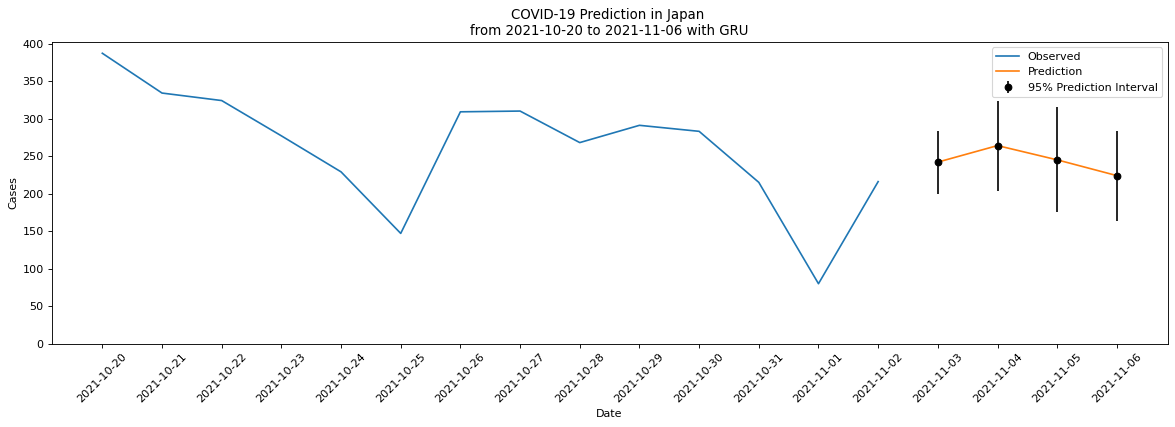

In [22]:
from matplotlib.pyplot import figure
figure(figsize=(18, 5), dpi=80)

plt.plot(time_range[:-4], df['Infected'][-14:], label='Observed')
plt.plot(time_range[-4:], y_pred, label='Prediction')

plt.errorbar(time_range[-4], y_pred[0], yerr=cov_intervals[0], color='black', fmt='o', label='95% Prediction Interval')
plt.errorbar(time_range[-3], y_pred[1], yerr=cov_intervals[1], color='black', fmt='o')
plt.errorbar(time_range[-2], y_pred[2], yerr=cov_intervals[2], color='black', fmt='o')
plt.errorbar(time_range[-1], y_pred[3], yerr=cov_intervals[3], color='black', fmt='o')

plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(time_range,rotation=45)
plt.title('COVID-19 Prediction in Japan \nfrom {0} to {1} with {2}'.format(start_date, end_date, model_type))
plt.legend()
plt.ylim(0, None) # Or similarly "plt.ylim(0)" #important

plt.show()